<a href="https://colab.research.google.com/github/Meitalg88/MyColabNotebooks/blob/main/%D7%A4%D7%A8%D7%95%D7%99%D7%99%D7%A7%D7%98_%D7%91%D7%91%D7%99%D7%A0%D7%94_%D7%9E%D7%9C%D7%90%D7%9B%D7%95%D7%AA%D7%99%D7%AA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
port zipfile
import os

# Path to the ZIP file
zip_path = '/content/BloodMNIST_Dataset.zip'
extract_to_folder = '/content/bloodmnist_images'

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_folder)

# Check if the files were extracted successfully
if os.path.exists(extract_to_folder):
    print(f"Files extracted to: {extract_to_folder}")
else:
    print(f"Extraction failed for {zip_path}")

Files extracted to: /content/bloodmnist_images


In [ ]:
import os

# Path to the source directory (BloodMNIST root folder)
source_folder = '/content/bloodmnist_images'

# Paths to train, val, and test directories
train_dir = os.path.join(source_folder, 'train')
val_dir = os.path.join(source_folder, 'val')  # Corrected from "validation" to "val"
test_dir = os.path.join(source_folder, 'test')

# Verify the directories exist
for dir_path in [train_dir, val_dir, test_dir]:
    if not os.path.exists(dir_path):
        print(f"Directory {dir_path} does not exist. Please check the structure.")
        exit(1)

# Count images in each directory
def count_images_in_directory(dir_path):
    total_images = 0
    for root, dirs, files in os.walk(dir_path):
        image_files = [f for f in files if f.endswith('.png')]
        total_images += len(image_files)
    return total_images

# Count and display the number of images
train_count = count_images_in_directory(train_dir)
val_count = count_images_in_directory(val_dir)
test_count = count_images_in_directory(test_dir)

print(f"Training images: {train_count}")
print(f"Validation images: {val_count}")
print(f"Test images: {test_count}")

Training images: 11959
Validation images: 1712
Test images: 3421


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data generator without augmentation
datagen = ImageDataGenerator(
    rescale=1./255  # Normalizing pixel values to [0, 1]
)


train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(32, 32),
    batch_size=64,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(32, 32),
    batch_size=64,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(32, 32),
    batch_size=64,
    class_mode='categorical',
    shuffle=False  # חשוב: אין ערבוב של הנתונים במחולל הבדיקה
)

Found 11959 images belonging to 8 classes.
Found 1712 images belonging to 8 classes.
Found 3421 images belonging to 8 classes.


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Build the model with new input_shape (32x32)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Adding custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reducing spatial dimensions to one per feature map
x = Dense(256, activation='relu')(x)  # Additional Dense layer to strengthen representations
x = BatchNormalization()(x)  # BatchNormalization after Dense layer
x = Dropout(0.4)(x)  # Dropout for model regularization
predictions = Dense(8, activation='softmax')(x)  # 8 categories for classification

# Building the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freezing the first layers of the DenseNet121 model
for layer in base_model.layers[:100]:  # Freezing the first layers
    layer.trainable = False
for layer in base_model.layers[100:]:  # Unfreezing the last layers
    layer.trainable = True

# Compile the model without ExponentialDecay (removing it)
optimizer = Adam(learning_rate=1e-4)  # Using a fixed learning rate of 1e-4

model.compile(optimizer=optimizer,  # Adding the optimizer with a fixed learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Compute class weights for handling class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

# Print class weights per category
categories = train_generator.class_indices
print("Class weights per category:")
for category, weight in zip(categories.keys(), class_weights):
    print(f"{category}: {weight:.2f}")

Class weights per category:
[0]: 1.75
[1]: 0.69
[2]: 1.38
[3]: 0.74
[4]: 1.76
[5]: 1.51
[6]: 0.64
[7]: 0.91


In [ ]:
# Define EarlyStopping - stop early if no improvement
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the loss value on the Validation set
    patience=3,          # Stop after 3 epochs with no improvement
    restore_best_weights=True  # Restore the best weights
)

# Define ReduceLROnPlateau - reduce learning rate if no improvement in Validation loss
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,          # Reduce learning rate by 50%
    patience=2,          # Stop after 2 epochs with no improvement
    min_lr=1e-6,         # Minimum learning rate
    verbose=1            # Print messages
)

In [ ]:
def evaluate_model(data_generator, model, dataset_name):

    # הערכה של המודל על מחולל הנתונים
    results = model.evaluate(data_generator, verbose=1)

    # הדפסת התוצאות
    print(f"\nתוצאות עבור {dataset_name}:")
    for metric_name, value in zip(model.metrics_names, results):
        print(f"{metric_name}: {value:.4f}")

In [ ]:
# Running the training with class weights and callbacks
history = model.fit(
    train_generator,
    epochs=70,  # Number of epochs
    validation_data=val_generator,
    class_weight=class_weights_dict,  # Adding class weights
    callbacks=[early_stopping, reduce_lr]  # Adding callbacks
)

Epoch 1/70


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


187/187 ━━━━━━━━━━━━━━━━━━━━ 227s 802ms/step - accuracy: 0.4144 - loss: 2.0118 - val_accuracy: 0.7132 - val_loss: 0.9085 - learning_rate: 1.0000e-04
Epoch 2/70
187/187 ━━━━━━━━━━━━━━━━━━━━ 199s 786ms/step - accuracy: 0.7830 - loss: 0.6781 - val_accuracy: 0.8423 - val_loss: 0.4600 - learning_rate: 1.0000e-04
Epoch 3/70
187/187 ━━━━━━━━━━━━━━━━━━━━ 203s 788ms/step - accuracy: 0.8586 - loss: 0.4397 - val_accuracy: 0.8604 - val_loss: 0.4072 - learning_rate: 1.0000e-04
Epoch 4/70
187/187 ━━━━━━━━━━━━━━━━━━━━ 145s 773ms/step - accuracy: 0.9027 - loss: 0.2975 - val_accuracy: 0.8803 - val_loss: 0.3310 - learning_rate: 1.0000e-04
Epoch 5/70
187/187 ━━━━━━━━━━━━━━━━━━━━ 145s 777ms/step - accuracy: 0.9205 - loss: 0.2304 - val_accuracy: 0.8925 - val_loss: 0.3177 - learning_rate: 1.0000e-04
Epoch 6/70
187/187 ━━━━━━━━━━━━━━━━━━━━ 201s 771ms/step - accuracy: 0.9435 - loss: 0.1710 - val_accuracy: 0.9048 - val_loss: 0.2874 - learning_rate: 1.0000e-04
Epoch 7/70
187/187 ━━━━━━━━━━━━━━━━━━━━ 145s 774ms/

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# חיזוי על מחולל הבדיקה
y_pred_prob = model.predict(test_generator, verbose=1, steps=len(test_generator))
y_pred = np.argmax(y_pred_prob, axis=1)  # המרת ההסתברויות למחלקות

# תוויות אמיתיות
y_true = test_generator.classes

# שמות המחלקות (מילון שמות המחלקות לפי המחולל)
class_labels = list(test_generator.class_indices.keys())

# דוח המדדים (Precision, Recall, F1)
report = classification_report(
    y_true,
    y_pred,
    target_names=class_labels,  # שמות המחלקות
    digits=4  # פורמט להצגת תוצאות עד 4 ספרות אחרי הנקודה
)

# הדפסת הדוח
print("\nClassification Report:")
print(report)

# מטריצת בלבול (לא חובה, אבל שימושית)
conf_matrix = confusion_matrix(y_true, y_pred)

print("\nConfusion Matrix:")
print(conf_matrix)


54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 337ms/step

Classification Report:
              precision    recall  f1-score   support

         [0]     0.7572    0.8566    0.8038       244
         [1]     0.9867    0.9535    0.9698       624
         [2]     0.9213    0.9035    0.9123       311
         [3]     0.7913    0.7858    0.7886       579
         [4]     0.8716    0.9218    0.8960       243
         [5]     0.8105    0.8134    0.8120       284
         [6]     0.9448    0.9249    0.9347       666
         [7]     0.9936    0.9894    0.9915       470

    accuracy                         0.8992      3421
   macro avg     0.8846    0.8936    0.8886      3421
weighted avg     0.9013    0.8992    0.8999      3421


Confusion Matrix:
[[209   1   1  20   6   5   2   0]
 [  6 595   0  14   1   0   8   0]
 [  4   0 281  11   5   2   5   3]
 [ 41   4   5 455  11  43  20   0]
 [  8   0   1  10 224   0   0   0]
 [  7   0   2  38   6 231   0   0]
 [  1   3  11  27   4   4 616   0]
 [  0   0   4   0  

In [ ]:
score = model.evaluate(val_generator)
print(f"Validation loss: {score[0]}")
print(f"Validation accuracy: {score[1]}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 391ms/step - accuracy: 0.8978 - loss: 0.3073
Validation loss: 0.2873930335044861
Validation accuracy: 0.9047897458076477


In [ ]:
# הערכת המודל על נתוני ה-test
score = model.evaluate(test_generator)  # השתמש ב-test_generator
print('Test loss:', score[0])  # מדפיס את הפסד המודל
print('Test accuracy:', score[1])  # מדפיס את הדיוק על נתוני ה-test

54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 235ms/step - accuracy: 0.8929 - loss: 0.3476
Test loss: 0.32709112763404846
Test accuracy: 0.8991522789001465


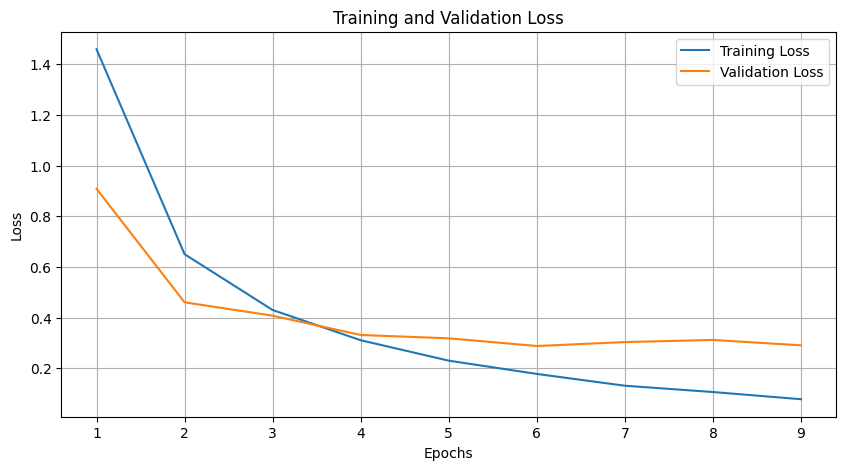

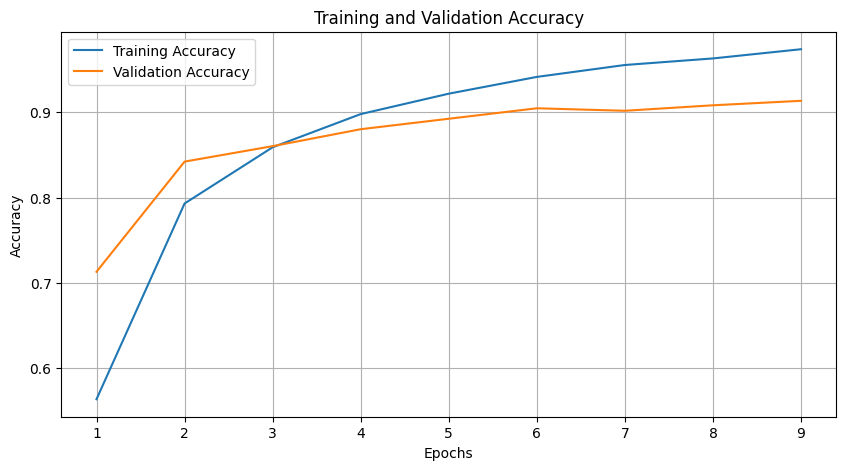

In [ ]:
import matplotlib.pyplot as plt

# Extracting loss and accuracy from history
loss = history.history['loss']  # Training loss
val_loss = history.history['val_loss']  # Validation loss
accuracy = history.history['accuracy']  # Training accuracy
val_accuracy = history.history['val_accuracy']  # Validation accuracy
epochs = range(1, len(loss) + 1)  # Epoch numbers

# Plotting the loss graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the accuracy graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


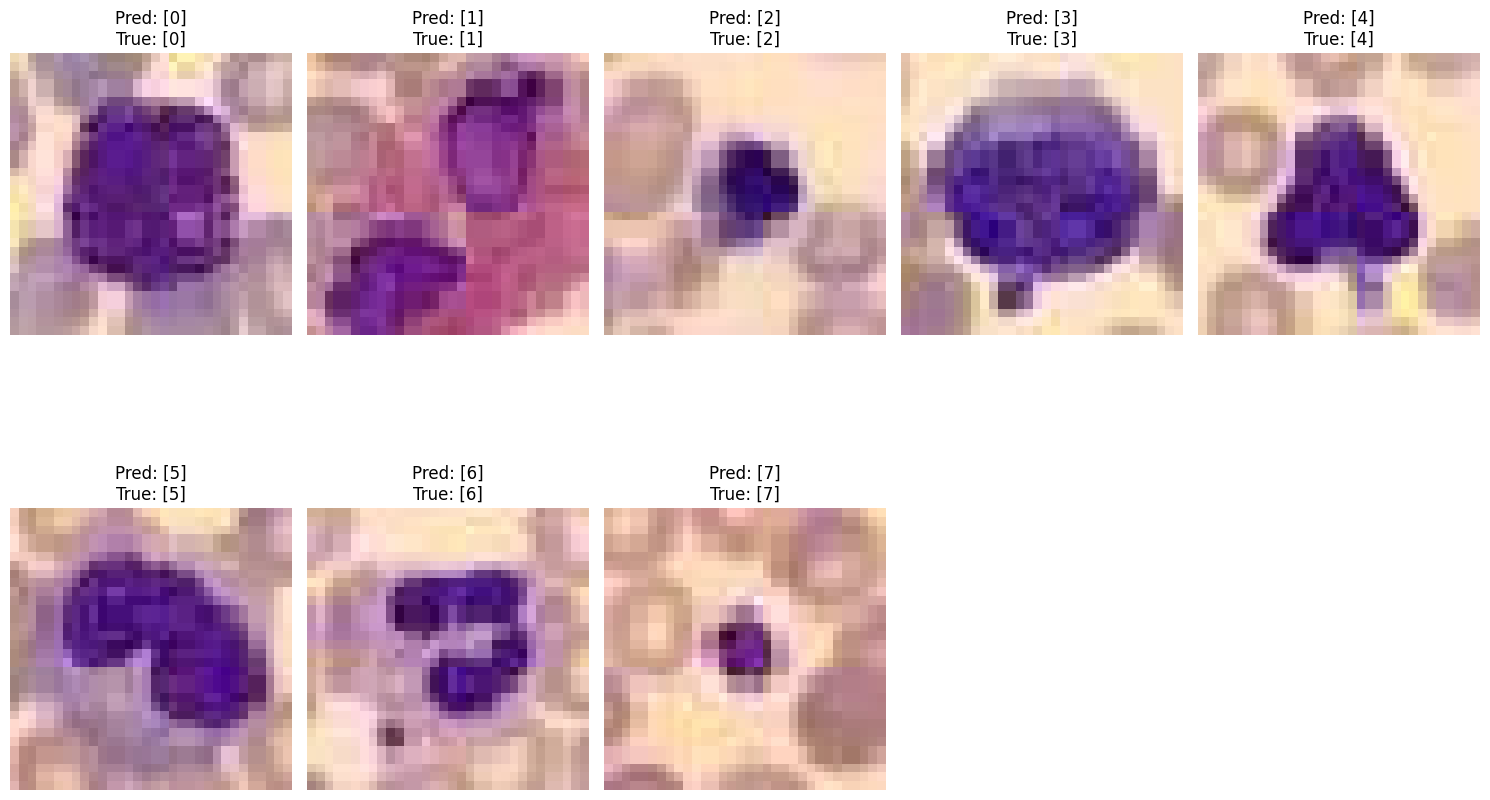

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import array_to_img

def display_images_from_different_classes(data_generator, model, num_images=10):
    # קבלת כל המחלקות ממחולל הנתונים
    class_indices = data_generator.class_indices
    class_names = list(class_indices.keys())
    num_classes = len(class_names)

    # שמירה של אינדקסים שנבחרו מכל מחלקה
    selected_images = []
    selected_labels = []

    # חיפוש תמונה אחת לפחות מכל מחלקה
    for _ in range(len(data_generator)):
        images, labels = next(data_generator)
        true_classes = np.argmax(labels, axis=1)

        for i in range(len(images)):
            class_id = true_classes[i]
            if class_id not in selected_labels:
                selected_images.append(images[i])
                selected_labels.append(class_id)

            if len(selected_images) >= num_images:  # מספיק תמונות
                break
        if len(selected_images) >= num_images:
            break

    # ביצוע חיזוי על התמונות שנבחרו
    selected_images = np.array(selected_images)
    predictions = model.predict(selected_images)
    predicted_classes = np.argmax(predictions, axis=1)

    # הגדרת גודל הגרף
    plt.figure(figsize=(15, 10))
    for i in range(len(selected_images)):
        plt.subplot(2, 5, i + 1)  # מיקום בגריד
        img = array_to_img(selected_images[i])  # המרה לפורמט תמונה להצגה
        plt.imshow(img)
        plt.axis('off')

        # כיתוב עם חיזוי ותווית אמיתית
        true_label = class_names[selected_labels[i]]
        pred_label = class_names[predicted_classes[i]]
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}")

    plt.tight_layout()
    plt.show()

# קריאה לפונקציה להצגת תמונות ממחלקות שונות
display_images_from_different_classes(test_generator, model, num_images=10)

In [ ]:
# שמירת המודל המאומן
model.save('my_model.h5')  # שמירת המודל בקובץ בפורמט H5
print("Model saved successfully!")

Model saved successfully!


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# חיזוי על סט הבדיקה
y_pred_prob = model.predict(test_generator, verbose=1, steps=len(test_generator))
y_pred = np.argmax(y_pred_prob, axis=1)  # המרת ההסתברויות למחלקות
y_true = test_generator.classes  # תוויות אמיתיות

# חישוב Precision, Recall, ו-F1
precision = precision_score(y_true, y_pred, average='macro')  # Precision כולל
recall = recall_score(y_true, y_pred, average='macro')        # Recall כולל
f1 = f1_score(y_true, y_pred, average='macro')                # F1 כולל

# הצגת התוצאות
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 256ms/step
Precision: 0.8846
Recall: 0.8936
F1 Score: 0.8886
